<a href="https://colab.research.google.com/github/chihebmezrigui1/Analyse_N_gram_DATA/blob/main/brain_tumor_detecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all the libraries**

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from warnings import filterwarnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']

**Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

print(os.listdir('/content/drive/MyDrive'))

['Diagramme sans nom (3).drawio', 'Diagramme sans nom (2).drawio', 'Rapport PFE Chihab Mezrigui.gdoc', 'Rapport PFE Chihab Mezrigui avancement (1) (Réparé).gdoc', 'Rapport PFE Chihab avancement.gdoc', 'diagrams', 'forgotpassword.drawio', 'DiagrammeClasseSprint2.drawio', 'vermeg .gdoc', 'CV CHIHAB MEZRIGUI English (1).pdf', 'CV CHIHAB MEZRIGUI English.pdf', 'conception', 'Diagramme sans nom (1).drawio', 'Rapport Chiheb Mezrigui version 2.docx', 'correc diag seq signin .png', 'Document sans titre (16).gdoc', 'diagrammeclasseConceptionSprint2.drawio', '#Speech 1 :.gdoc', 'IMG_1346.MOV', 'IMG_1347.MOV', 'IMG_1352.MOV', 'IMG_1344.MOV', 'IMG_1351.MOV', 'IMG_1350.MOV', 'IMG_1348.MOV', 'IMG_1343.MOV', 'IMG_1345.MOV', 'IMG_1349.MOV', 'Video cpu', 'IMG_1361.MOV', 'Document sans titre (15).gdoc', 'Dossier Etudiant', 'Projet d’étude.gdoc', 'Mon stage PFE.gdoc', 'matières.gdoc', 'Paragraphe motivation.gdoc', 'Graduation', 'acte_naissance.pdf', 'liasse de documents avec annexes.pdf', 'liasse de 

In [ ]:
# Nous commençons d'abord par parcourir et redimensionner toutes les images des répertoires,
# puis nous les ajoutons dans deux listes distinctes, à savoir x et y.

In [ ]:
# Nous commençons par parcourir et redimensionner toutes les images
# des répertoires et les ajouter dans deux listes distinctes : x et y.

labels = ['glioma', 'notumor', 'meningioma', 'pituitary']

x = []
y = []
image_size = 224  # toutes les images seront redimensionnées en 224 x 224

# Chargement des images d'entraînement
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI_Dataset', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):  # os.listdir retourne tous les fichiers du dossier 'folderPath'
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        x.append(img)
        y.append(i)

# Chargement des images de test
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI_Dataset', 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        x.append(img)
        y.append(i)

# Ensuite, nous convertissons toutes les images redimensionnées et les étiquettes en tableaux numpy.

x = np.array(x)
y = np.array(y)


100%|██████████| 300/300 [00:06<00:00, 44.98it/s] 


**Analyse exploratoire des données**

/tmp/ipython-input-854850905.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="labels", data=df, palette="muted")  # palette pour colorer les barres


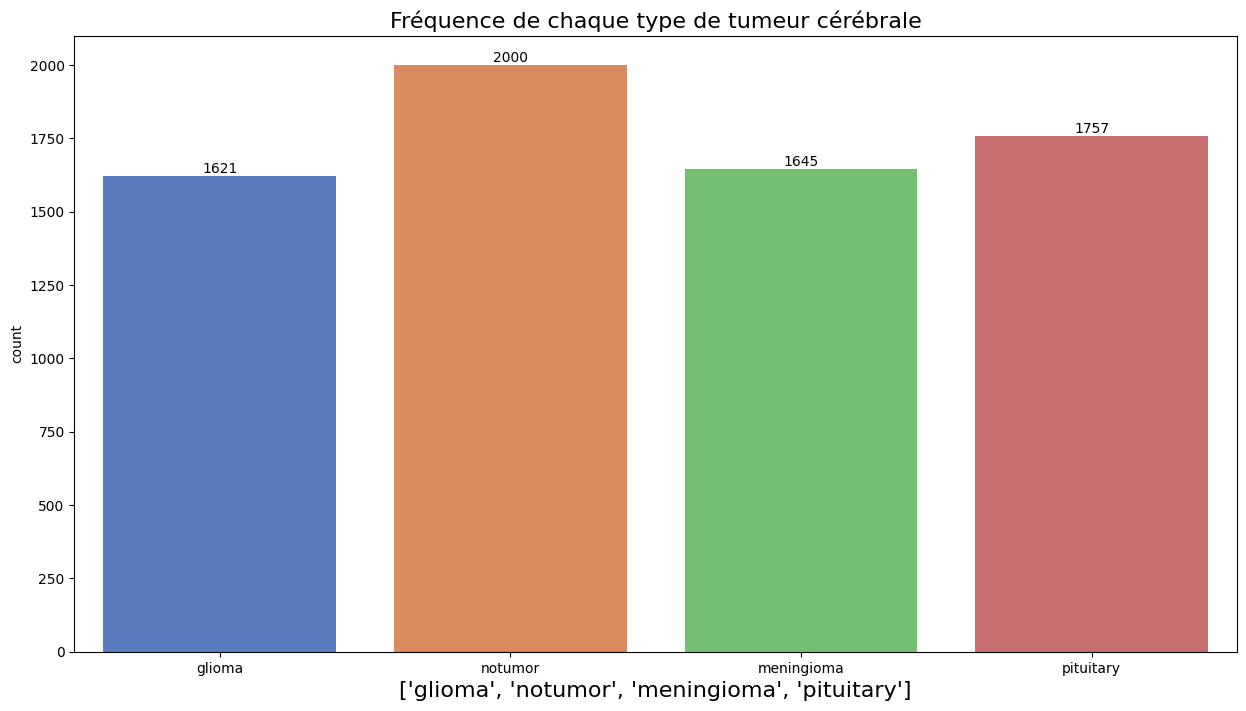

In [ ]:
# Afficher les images IRM de chaque classe dans un ordre aléatoire
df = pd.DataFrame(y, columns=['labels'])

def freq_plot(column_name):
  plt.figure(figsize=(15,8))
  ax = sns.countplot(x="labels", data=df, palette="muted")  # palette pour colorer les barres
  plt.title("Fréquence de chaque type de tumeur cérébrale", fontsize=16)
  plt.xlabel(f"{column_name}", fontsize=16)

  # ✅ Afficher les valeurs sur toutes les barres
  for container in ax.containers:
      ax.bar_label(container, label_type='edge')

  plt.show()

freq_plot(labels)


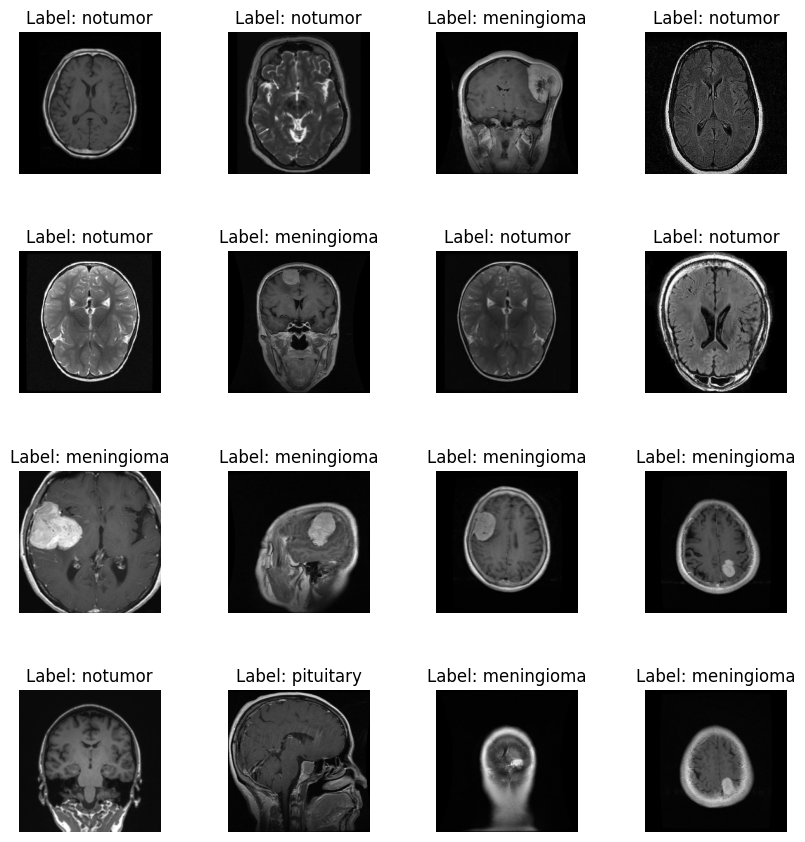

In [ ]:
# Afficher les images IRM de chaque classe dans un ordre aléatoire
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

for i in range(0, grid_width):
  for j in range(0, grid_height):
        c = random.randint(0,5000)
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+y[c])
        ax[i][j].imshow(x[c])

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)

In [ ]:
print(f"Size and shape of the training dataset is {x.shape}")

print(f'\nSize and shape of the testing dataset is {y.shape}')

Size and shape of the training dataset is (7023, 224, 224, 3)

Size and shape of the testing dataset is (7023,)


**# Division du jeu de données en ensemble d’entraînement et de test (avec train_test_split)**

In [ ]:
x, y = shuffle(x, y, random_state=101) ## Mélanger les images et leurs étiquettes

# Diviser le jeu de données : 20% pour le test et 80% pour l’entraînement
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2, random_state=101)

In [ ]:
# Vérifier la forme (shape) de x_train, x_test, y_train et y_test
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(5618, 224, 224, 3)
(1405, 224, 224, 3)
(5618,)
(1405,)


**Effectuer un encodage one-hot sur les étiquettes**
C’est l’étape où l’on transforme les étiquettes de classes (par ex. "glioma", "meningioma", "notumor", "pituitary") en un format numérique compréhensible par le modèle.

In [ ]:
y_train_new = []

for i in y_train:
  y_train_new.append(labels.index(i))

y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []

for i in y_test:
  y_test_new.append(labels.index(i))

y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [ ]:
#print the shape de y_train and y_test))
print(type(y_test))
print(y_train)
print(y_test)

<class 'numpy.ndarray'>
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


**EfficientNet-B0 Implementation : Model 1 (Simple Model)**

In [ ]:
# Nettoyer les nœuds laissés par la session précédente pour libérer de la mémoire et éviter les ralentissements.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam


no_of_classes = 4                 # il y a 4 sorties : notumor, glioma, meningioma et pituitary
size = (image_size, image_size)   # image_size a été défini plus tôt comme 224

# La variable "inputs" est créée pour que le modèle EfficientNet accepte l'entrée au format 224x224x3
inputs = layers.Input(shape=(image_size, image_size, 3))

efficient_net1 = EfficientNetB0(
    weights=None,                 # weights = None car on n’utilise pas le transfert d’apprentissage, on construit un classifieur personnalisé
    include_top=True,             # include_top = True afin d’accéder aux dernières couches denses
    classes=no_of_classes         # nombre de sorties (4 classes)
)(inputs)


In [ ]:
model1 = tf.keras.Model(inputs, efficient_net1)
model1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4)              │     4,054,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


In [ ]:
# Result : sortie de model correspond à 4 neurones (les labels)
# Param #: 4,054,695
# → nombre total de paramètres dans ce modèle (poids et biais).

In [ ]:
hist1 = model1.fit(x_train, y_train,
                   validation_split = 0.1,
                   epochs=20,
                   verbose = 1,
                   batch_size = 32)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 128s 258ms/step - accuracy: 0.4612 - loss: 1.8163 - val_accuracy: 0.2082 - val_loss: 3.9119
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 70s 116ms/step - accuracy: 0.7139 - loss: 0.7589 - val_accuracy: 0.3363 - val_loss: 1.7970
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.7894 - loss: 0.5999 - val_accuracy: 0.5534 - val_loss: 1.1853
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8377 - loss: 0.4147 - val_accuracy: 0.8505 - val_loss: 0.4121
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8953 - loss: 0.2768 - val_accuracy: 0.8434 - val_loss: 0.4449
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9326 - loss: 0.1652 - val_accuracy: 0.7811 - val_loss: 0.7575
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9527 - loss: 0.1256 - val_accuracy: 0.9075 - val_loss: 0.2982
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9742 - loss: 

In [ ]:
# Sauvegarde au format Keras (.keras) → simple et portable
model1.save("EfficientNetB0_Model.keras")

# OU format TensorFlow SavedModel (si tu veux le déployer avec TF-Serving plus tard)
# model1.save("EfficientNetB0_SavedModel")

In [ ]:
from google.colab import files
files.download("EfficientNetB0_Model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Evaluating Model 1**

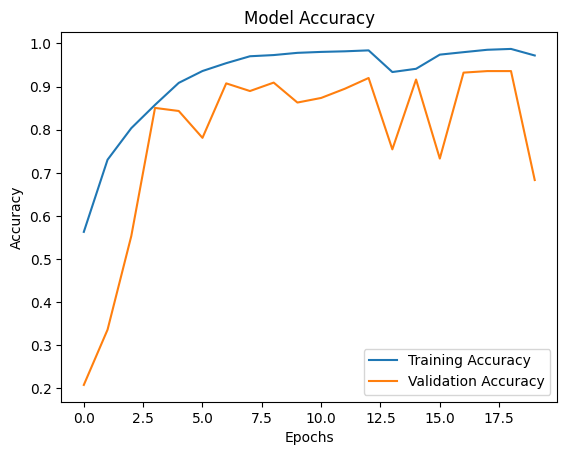

In [ ]:
#plotting the performance metrics
import matplotlib.pyplot as plt

plt.subplot(111)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.plot(hist1.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label = 'Validation Accuracy')

plt.legend()
plt.show()

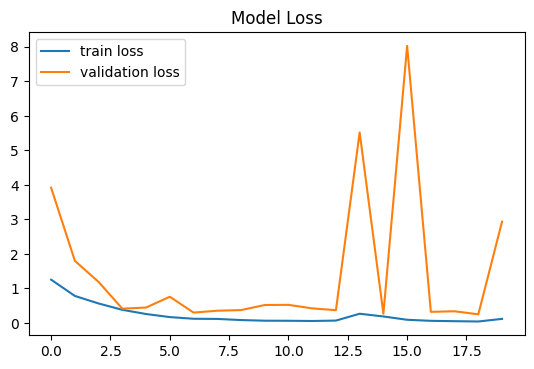

In [ ]:
plt.subplots_adjust(top=1.5)
plt.subplot(211)
plt.title('Model Loss')
plt.plot(hist1.history['loss'], label='train loss')
plt.plot(hist1.history['val_loss'], label='validation loss')
plt.legend()

Le modèle apprend bien (car les deux courbes augmentent).

Overfitting léger : la précision d’entraînement est proche de 1.0, mais la validation plafonne autour de 0.9 → ton modèle mémorise un peu trop les données d’entraînement.

Chute à epoch 10 : souvent lié à un learning rate trop élevé, ou un batch difficile. Comme ça remonte vite, ce n’est pas dramatique

**Testing Accuracy on Model 1**

In [ ]:
#Using unseen data to test the model
preds = model1.evaluate(x_test, y_test)
print("Loss = " + str(preds[0]))
print("Testing Accuracy of Model 1 is " + str(preds[1]))

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.7198 - loss: 1.6879
Loss = 1.901654601097107
Testing Accuracy of Model 1 is 0.717437744140625


**Confusion Matrix et Classification metrics of Model 1**

In [ ]:
pred1 = model1.predict(x_test)
pred1 = np.argmax(pred1, axis = 1)

y_test_new_model_1 = np.argmax(y_test, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step


In [ ]:
# print the text report showing the main classification metrics.
print(classification_report(y_test_new_model_1, pred1))

              precision    recall  f1-score   support

           0       0.51      0.99      0.67       348
           1       0.88      0.98      0.93       398
           2       0.95      0.29      0.45       342
           3       0.98      0.54      0.70       317

    accuracy                           0.72      1405
   macro avg       0.83      0.70      0.69      1405
weighted avg       0.83      0.72      0.70      1405



In [ ]:
import matplotlib.cm as cm
colors_red = cm.get_cmap("Reds")(range(256))  # 256 nuances de rouge

/tmp/ipython-input-3211397011.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_red = cm.get_cmap("Reds")(range(256))  # 256 nuances de rouge


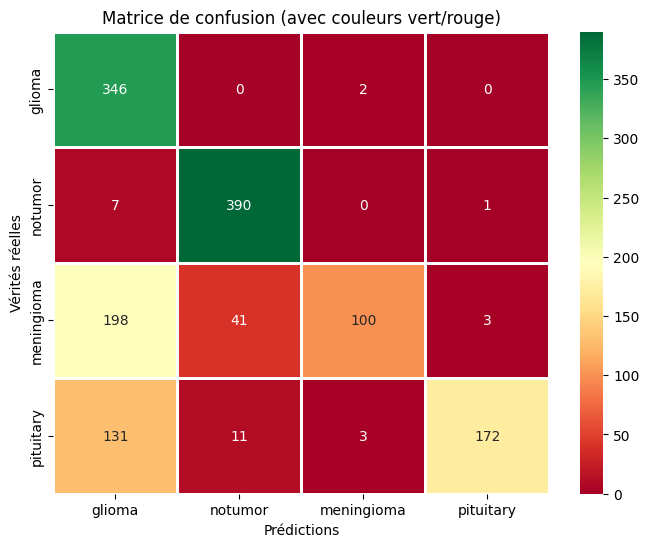

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_new_model_1, pred1)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt="g",
            cmap="RdYlGn",   # ✅ vert = bon, rouge = erreur
            xticklabels=labels,
            yticklabels=labels,
            linewidths=2,
            linecolor='white')

plt.title("Matrice de confusion (avec couleurs vert/rouge)")
plt.xlabel("Prédictions")
plt.ylabel("Vérités réelles")
plt.show()


**EfficientNet-B0 Implementation : Model 2 (Tuning)**

In [ ]:

efficient_net2 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3 ))

#utilize the weights trained on Imagenet on this model
#include_top parameter set to false so that the network doesn't include the top layers/output layer
#this allows us to add our own output layer


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# designing the model architecture
model2 = efficient_net2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation = 'softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficient_net2.input, outputs = model2)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
#show the total number of layers in model 2
print(len(model2.layers))

241


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Définition de l’optimiseur
optimizer = Adam(learning_rate=0.0001)

# Early stopping → arrêter l’entraînement si la val_loss ne s’améliore plus
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

# Réduction du learning rate quand la val_loss stagne
rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

# Compilation du modèle
model2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


**Training Model 2**

In [ ]:

hist2 = model2.fit(x_train, y_train, validation_split=0.1,
                   callbacks = [early_stop, rlrop] ,      # Pass callback to training
                   epochs = 40 ,
                   verbose = 1,
                   batch_size = 64)

Epoch 1/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 512ms/step - accuracy: 0.6495 - loss: 0.9023 - val_accuracy: 0.8577 - val_loss: 0.3821 - learning_rate: 1.0000e-04
Epoch 2/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.9311 - loss: 0.2083 - val_accuracy: 0.9466 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 3/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.9733 - loss: 0.0905 - val_accuracy: 0.9573 - val_loss: 0.1382 - learning_rate: 1.0000e-04
Epoch 4/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9899 - loss: 0.0445 - val_accuracy: 0.9555 - val_loss: 0.1440 - learning_rate: 1.0000e-04
Epoch 5/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9933 - loss: 0.0261 - val_accuracy: 0.9626 - val_loss: 0.1334 - learning_rate: 1.0000e-04
Epoch 6/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.9961 - loss: 0.0163 - val_accuracy: 0.9715 - val_loss: 0.1043 - learning_rate: 1.0000e-04
Epoch 7/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - ac

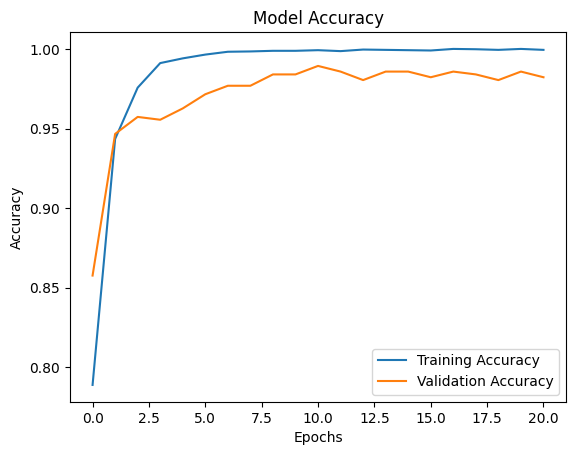

In [ ]:
#plot the performance metrics
import matplotlib.pyplot as plt

plt.subplot(111)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.plot(hist2.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label = 'Validation Accuracy')

plt.legend()
plt.show()

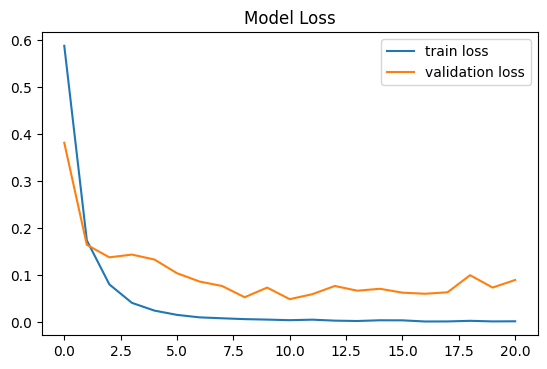

In [ ]:
plt.subplots_adjust(top=1.5)
plt.subplot(211)
plt.title('Model Loss')
plt.plot(hist2.history['loss'], label='train loss')
plt.plot(hist2.history['val_loss'], label='validation loss')
plt.legend()

**Testing the accuracy of Model 2 on unseen data**

In [ ]:
#Using unseen data to test the model
preds = model2.evaluate(x_test, y_test)
print("Loss = " + str(preds[0]))
print("Testing Accuracy of Model 2 is " + str(preds[1]))

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9919 - loss: 0.0224
Loss = 0.025653809309005737
Testing Accuracy of Model 2 is 0.9914590716362


**Confusion Matrix and Classification metrics of Model 2**

In [ ]:
pred2 = model2.predict(x_test)
pred2 = np.argmax(pred2, axis = 1)

y_test_new_model_2 = np.argmax(y_test, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
# print the text report showing the main classification metrics.

print(classification_report(y_test_new_model_2, pred2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       348
           1       1.00      0.99      1.00       398
           2       0.99      0.98      0.98       342
           3       0.99      1.00      0.99       317

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405



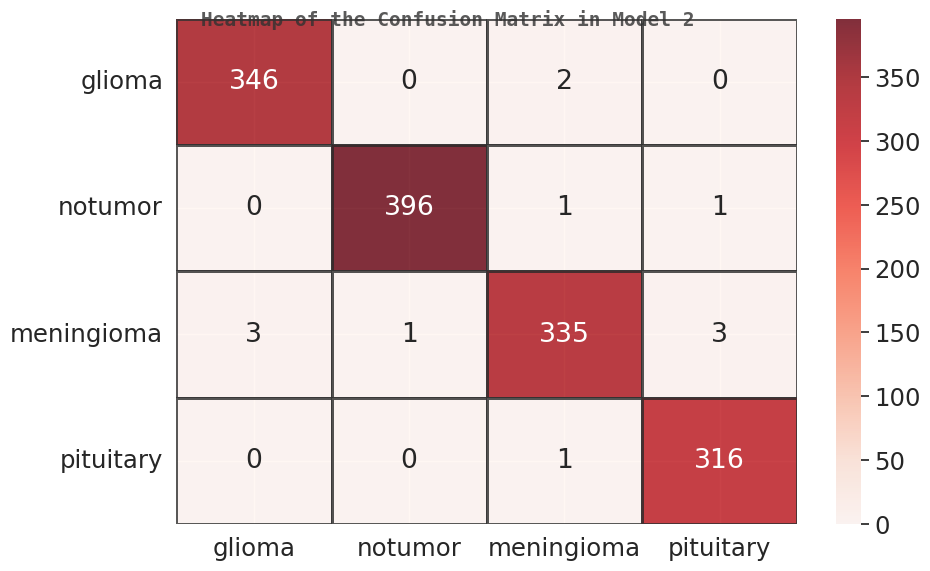

In [ ]:
# Matrice de confusion (Model 2)
fig, ax = plt.subplots(figsize=(10,6))  # taille plus raisonnable
sns.set(font_scale=1.6)

sns.heatmap(
    confusion_matrix(y_test_new_model_2, pred2),
    ax=ax,
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
    cmap="Reds",      # ou "Reds_r" pour inverser
    alpha=0.8,
    linewidths=1.0,
    linecolor="#313131",
    fmt="g"
)

fig.text(
    s="Heatmap of the Confusion Matrix in Model 2",
    size=14,
    fontweight="bold",
    fontname="monospace",
    color="#313131",
    y=0.94,
    x=0.22,
    alpha=0.8
)

plt.tight_layout()
plt.show()
